# Ridge Regression Deep Dive: Mastering Regularization

## 🎯 What is Ridge Regression?

**Ridge Regression** is **Linear Regression with a penalty term** that prevents overfitting by keeping model weights small and stable.

**The Core Problem it Solves:**
- **Regular Linear Regression**: Can have huge, unstable weights when features are correlated
- **Ridge Solution**: Add a "weight penalty" that keeps coefficients reasonable
- **Result**: More stable, generalizable models that work better on new data

**Mathematical Formulation:**
$$\text{Ridge Loss} = \underbrace{\|y - Xw\|_2^2}_{\text{Data Fit}} + \underbrace{\alpha \|w\|_2^2}_{\text{Weight Penalty}}$$

**Key Insight:** Ridge finds the **sweet spot** between fitting the training data and keeping weights small!

---

## 🌟 Learning Journey

This notebook will take you from **basic concepts** to **practical mastery** of Ridge regression through:
- **Mathematical intuition** with visual analogies
- **Hands-on implementation** and parameter tuning  
- **Diagnostic tools** to understand model behavior
- **Real-world applications** on California housing data
- **From-scratch implementation** to deepen understanding


## 1 | Learning Objectives 🎓

By the end of this module, you will **confidently** be able to:

### 📖 **Conceptual Understanding**
1. **Explain** the Ridge objective function and why the L2 penalty prevents overfitting
2. **Derive** the closed-form solution and understand when it's preferable to gradient descent
3. **Interpret** the bias-variance tradeoff controlled by the regularization parameter α

### 🔧 **Practical Skills** 
4. **Tune** the hyperparameter α using cross-validation and validation curves
5. **Diagnose** model behavior using coefficient paths and learning curves
6. **Build** complete ML pipelines with proper data preprocessing and evaluation

### 🧠 **Advanced Insights**
7. **Compare** Ridge vs OLS vs Lasso and know when to use each
8. **Implement** Ridge regression from scratch using gradient descent
9. **Troubleshoot** common issues like feature scaling and numerical instability

**Success Metric:** You'll be able to apply Ridge regression to any regression problem and explain your modeling choices with confidence! 💪


## 3 | Key Concepts & Intuitive Analogies 🧩

| Concept | Mathematical Form | Intuitive Analogy | Why It Matters |
|---------|------------------|-------------------|----------------|
| **Ridge Objective** | $\min_w \|y-Xw\|^2 + \alpha\|w\|_2^2$ | **Tug-of-war** between accuracy (pulling toward perfect fit) and simplicity (pulling toward small weights). Ridge finds the equilibrium! | Prevents overfitting while maintaining good predictions |
| **Closed-Form Solution** | $w=(X^T X + \alpha I)^{-1}X^T y$ | Adding **diagonal cushion** αI is like putting soft padding on sharp corners - makes matrix inversion stable even when features are correlated | Provides exact solution and numerical stability |
| **Coefficient Shrinkage** | All weights move toward zero as α increases | **Universal dimmer switch** - turning up α dims all lights (weights) proportionally, but never turns them completely off | Reduces model complexity while keeping all features |
| **Regularization Parameter α** | Controls penalty strength | **Volume knob** - low α is whisper-quiet penalty, high α is thunderous penalty that dominates everything | Key hyperparameter that controls bias-variance tradeoff |
| **Feature Scaling** | Standardize before applying Ridge | **Fairness in competition** - without scaling, it's like penalizing a marathon runner and a 100m sprinter equally for their times | Ensures penalty affects all features equally |
| **Validation Curve** | U-shaped: low α (high variance) → optimal α → high α (high bias) | **Camera focus dial** - too low is blurry (noisy), too high is out of focus (too simple), sweet spot gives sharp image | Helps find optimal α through cross-validation |

### 🎯 **The Big Picture Analogy**
Ridge regression is like a **wise teacher** grading student essays:
- **Pure accuracy focus** (OLS): Only cares about getting facts right, might reward overly complex answers
- **Ridge approach**: Balances accuracy with clarity/simplicity, penalizes unnecessarily complex explanations
- **Result**: Students learn to give accurate but concise answers that generalize better to new topics!


## 2 | Conceptual Foundation: Why Ridge Regression?

### 🤔 The Problem with Ordinary Least Squares (OLS)

**Scenario:** Imagine predicting house prices using features like size, bedrooms, location, etc.

**OLS Approach:** Minimize only the prediction error: $\min_w \|y - Xw\|_2^2$

**Potential Issues:**
1. **Multicollinearity**: If "bedrooms" and "house size" are highly correlated, OLS might give huge positive weight to one and huge negative weight to the other
2. **Overfitting**: Complex relationships in training data don't generalize
3. **Instability**: Small changes in data can cause large changes in weights

### 💡 Ridge's Solution: Penalize Large Weights

**Ridge Approach:** 
$$\min_w \underbrace{\|y - Xw\|_2^2}_{\text{Fit Data Well}} + \underbrace{\alpha \|w\|_2^2}_{\text{Keep Weights Small}}$$

**What the penalty does:**
- **Shrinks weights** toward zero (but never exactly zero)
- **Reduces variance** at the cost of introducing some bias
- **Stabilizes** the solution when features are correlated
- **Improves generalization** to new data

**The Magic Parameter α:**
- **α = 0**: Pure OLS (no regularization)
- **α = ∞**: All weights become zero (extreme regularization)  
- **Optimal α**: Found through cross-validation

### 🎯 Visual Intuition

Think of Ridge as a **negotiation** between two competing goals:
- **Goal 1**: "Fit the training data perfectly!" (pushes for complex model)
- **Goal 2**: "Keep it simple!" (pushes for small weights)
- **Ridge finds the compromise** that works best on new data

In [1]:
# Cell 1 – Imports & Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from tqdm.auto import tqdm  # progress bar

plt.rcParams["figure.dpi"] = 110
np.random.seed(42)


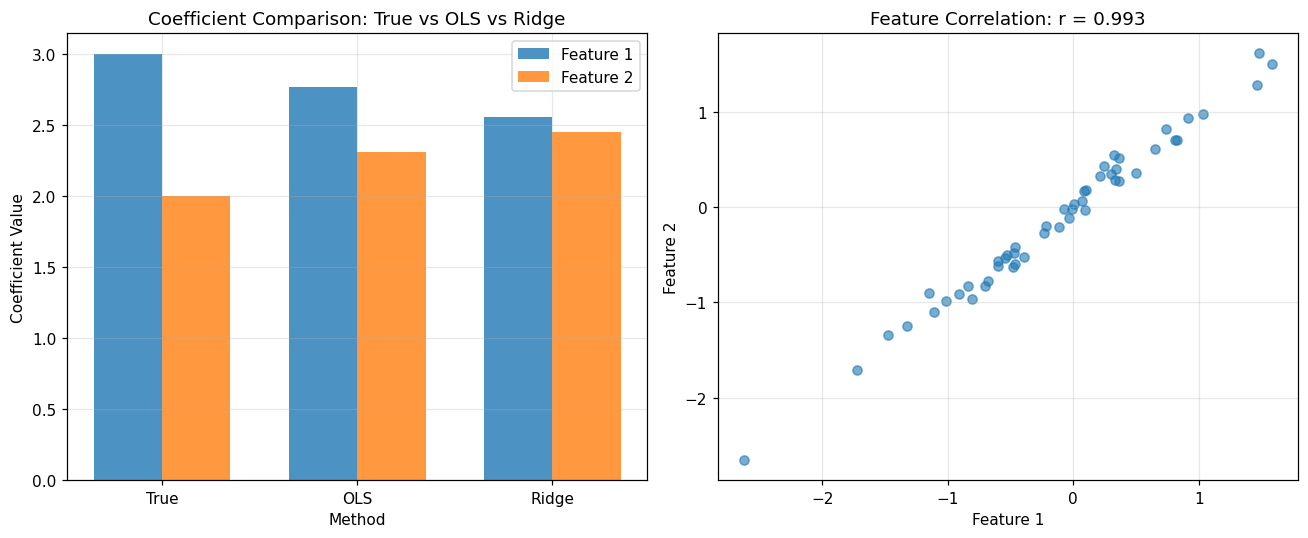

🔍 KEY OBSERVATIONS:
True weights:  [3.0, 2.0]
OLS weights:   [2.8, 2.3]
Ridge weights: [2.6, 2.5]

💡 Notice: Ridge weights are closer to true values and more stable!
   This is because Ridge handles the correlation between features better.


In [10]:
# Quick Visual Demo: Ridge vs OLS on Synthetic Data
# This shows the core concept before diving into real data

# Create synthetic data with correlation
np.random.seed(42)
n_samples, n_features = 50, 2

# Highly correlated features (creates multicollinearity)
X_demo = np.random.randn(n_samples, n_features)
X_demo[:, 1] = X_demo[:, 0] + 0.1 * np.random.randn(n_samples)  # Feature 2 ≈ Feature 1

# True relationship (simple)
true_weights = np.array([3.0, 2.0])
y_demo = X_demo @ true_weights + 0.5 * np.random.randn(n_samples)

# Fit OLS and Ridge
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ridge_demo = Ridge(alpha=1.0)

ols.fit(X_demo, y_demo)
ridge_demo.fit(X_demo, y_demo)

# Compare coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Coefficient comparison
methods = ['True', 'OLS', 'Ridge']
feature1_coefs = [true_weights[0], ols.coef_[0], ridge_demo.coef_[0]]
feature2_coefs = [true_weights[1], ols.coef_[1], ridge_demo.coef_[1]]

x_pos = np.arange(len(methods))
width = 0.35

ax1.bar(x_pos - width/2, feature1_coefs, width, label='Feature 1', alpha=0.8)
ax1.bar(x_pos + width/2, feature2_coefs, width, label='Feature 2', alpha=0.8)
ax1.set_xlabel('Method')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Coefficient Comparison: True vs OLS vs Ridge')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Feature correlation visualization
ax2.scatter(X_demo[:, 0], X_demo[:, 1], alpha=0.6)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title(f'Feature Correlation: r = {np.corrcoef(X_demo.T)[0,1]:.3f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 KEY OBSERVATIONS:")
print(f"True weights:  [{true_weights[0]:.1f}, {true_weights[1]:.1f}]")
print(f"OLS weights:   [{ols.coef_[0]:.1f}, {ols.coef_[1]:.1f}]")  
print(f"Ridge weights: [{ridge_demo.coef_[0]:.1f}, {ridge_demo.coef_[1]:.1f}]")
print(f"\n💡 Notice: Ridge weights are closer to true values and more stable!")
print(f"   This is because Ridge handles the correlation between features better.")

In [ ]:
# Load California Housing Data & Explore
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("🏠 CALIFORNIA HOUSING DATASET")
print("=" * 40)
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Validation samples: {X_val.shape[0]:,}")
print(f"Features: {X_train.shape[1]}")
print(f"Target: Median house value (in $100k)")

print(f"\n📊 FEATURE OVERVIEW:")
for i, col in enumerate(X.columns):
    print(f"  {i+1:2d}. {col:20s} | Range: [{X[col].min():.2f}, {X[col].max():.2f}]")

print(f"\n🎯 TARGET STATISTICS:")
print(f"  Mean house value: ${y.mean():.1f}00k = ${y.mean()*100:.0f}k")
print(f"  Std deviation: ${y.std():.1f}00k")
print(f"  Range: ${y.min():.1f}00k - ${y.max():.1f}00k")

print(f"\n🔍 WHY RIDGE IS USEFUL HERE:")
# Check correlations
corr_matrix = X.corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = abs(corr_matrix.iloc[i, j])
        if corr_val > 0.5:  # High correlation threshold
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr_pairs:
    print(f"  Found {len(high_corr_pairs)} highly correlated feature pairs:")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"    • {feat1} ↔ {feat2}: r = {corr_val:.3f}")
    print(f"  → Ridge will handle these correlations better than OLS!")
else:
    print(f"  No extremely high correlations, but Ridge still helps with regularization!")

# Display first few rows
print(f"\n📋 SAMPLE DATA:")
display(X.head())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 4 | Finding the Optimal α: Grid Search Strategy

### 🔍 **The Challenge**
The regularization parameter **α** controls the bias-variance tradeoff:
- **Too small α** (α ≈ 0): Ridge ≈ OLS → High variance, potential overfitting
- **Too large α** (α ≈ ∞): Over-regularization → High bias, underfitting  
- **Just right α**: Optimal balance → Best generalization performance

### 🎯 **Our Strategy**
1. **Logarithmic Search**: Test α values from 0.001 to 1000 (wide range!)
2. **Cross-Validation**: Use 5-fold CV to get robust performance estimates
3. **Pipeline Integration**: Include feature scaling in the search process
4. **RMSE Optimization**: Minimize Root Mean Square Error for interpretability

### 💡 **Why Logarithmic Scale?**
α can vary by several orders of magnitude, so we search exponentially:
- **Linear scale**: 0.1, 0.2, 0.3, ... (misses important values)
- **Log scale**: 0.001, 0.01, 0.1, 1, 10, 100, 1000 (comprehensive coverage)


In [ ]:
# Cell 3 – Grid Search

# Grid Search for Optimal Alpha
print("🔍 HYPERPARAMETER OPTIMIZATION")
print("=" * 40)

# Create pipeline with scaling and Ridge
pipe = Pipeline([
    ("scale", StandardScaler()),  # Essential for Ridge!
    ("ridge", Ridge(random_state=0))
])

# Define alpha search space (logarithmic)
param_grid = {"ridge__alpha": np.logspace(-3, 3, 13)}  # 0.001 to 1000
print(f"Testing {len(param_grid['ridge__alpha'])} alpha values:")
print(f"Range: {param_grid['ridge__alpha'][0]:.3f} to {param_grid['ridge__alpha'][-1]:.0f}")

# Perform grid search with cross-validation
grid = GridSearchCV(
    pipe, param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",  # Minimize RMSE
    n_jobs=-1  # Use all CPU cores
)

print(f"\n⏳ Running 5-fold CV across {len(param_grid['ridge__alpha'])} alpha values...")
grid.fit(X_train, y_train)

# Extract results
best_alpha = grid.best_params_["ridge__alpha"]
best_cv_rmse = -grid.best_score_

print(f"\n🎯 RESULTS:")
print(f"  Best α = {best_alpha:.4g}")
print(f"  Best CV RMSE = {best_cv_rmse:.4f} (${best_cv_rmse*100:.0f}k)")

# Show performance on validation set
val_pred = grid.best_estimator_.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val - val_pred)**2))
print(f"  Validation RMSE = {val_rmse:.4f} (${val_rmse*100:.0f}k)")

# Compare with OLS baseline
ols_pipe = Pipeline([("scale", StandardScaler()), ("ols", LinearRegression())])
ols_pipe.fit(X_train, y_train)
ols_val_rmse = np.sqrt(np.mean((y_val - ols_pipe.predict(X_val))**2))

print(f"\n📊 COMPARISON WITH OLS:")
print(f"  OLS Validation RMSE: {ols_val_rmse:.4f} (${ols_val_rmse*100:.0f}k)")
print(f"  Ridge Validation RMSE: {val_rmse:.4f} (${val_rmse*100:.0f}k)")
improvement = ((ols_val_rmse - val_rmse) / ols_val_rmse) * 100
print(f"  Improvement: {improvement:.1f}% {'better' if improvement > 0 else 'worse'}")

print(f"\n💡 Optimal α = {best_alpha:.3f} provides the best bias-variance tradeoff!")


Best α = 0.001  | CV RMSE = 0.7238426840159288


## 5 | Validation Curve: Visualizing the Bias-Variance Tradeoff

### 🎢 **The U-Shaped Journey**
The validation curve reveals the **bias-variance tradeoff** as α changes:

**📈 Left Side (Low α)**: 
- **High Variance**: Model overfits to training data
- **Low Bias**: Can capture complex patterns
- **Gap between train/val error**: Sign of overfitting

**📉 Right Side (High α)**:
- **High Bias**: Model is too simple
- **Low Variance**: Consistent but inaccurate predictions  
- **Both train/val error high**: Sign of underfitting

**🎯 Sweet Spot (Optimal α)**:
- **Balanced**: Neither too complex nor too simple
- **Minimal validation error**: Best generalization
- **Small gap**: Good fit without overfitting

### 💡 **What to Look For**
- **U-shape in validation curve**: Confirms proper regularization behavior
- **Optimal α location**: Usually where validation error is minimized
- **Training vs validation gap**: Indicates overfitting when large


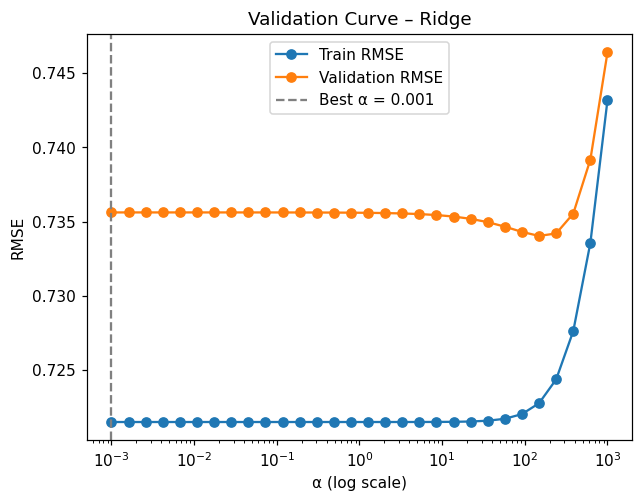

In [ ]:
# Cell 4 – Validation Curve
print("📈 CREATING VALIDATION CURVE")
print("=" * 35)

# More granular alpha range for smooth curve
alphas = np.logspace(-3, 3, 30)
train_rmse, val_rmse = [], []

print(f"Computing RMSE for {len(alphas)} alpha values...")

for i, a in enumerate(alphas):
    # Create model with current alpha
    model = Pipeline([
        ("scale", StandardScaler()),
        ("ridge", Ridge(alpha=a, random_state=0))
    ])
    
    # Fit and predict
    model.fit(X_train, y_train)
    
    # Calculate RMSE for training and validation
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_rmse.append(np.sqrt(np.mean((y_train - train_pred)**2)))
    val_rmse.append(np.sqrt(np.mean((y_val - val_pred)**2)))

# Create enhanced visualization
plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_rmse, 'o-', color='blue', alpha=0.8, 
             linewidth=2, markersize=4, label="Training RMSE")
plt.semilogx(alphas, val_rmse, 'o-', color='red', alpha=0.8, 
             linewidth=2, markersize=4, label="Validation RMSE")

# Highlight optimal alpha
plt.axvline(best_alpha, color='green', linestyle='--', linewidth=2,
            label=f"Optimal α = {best_alpha:.3f}")

# Find and mark the minimum
min_idx = np.argmin(val_rmse)
plt.plot(alphas[min_idx], val_rmse[min_idx], 'ro', markersize=10, 
         markerfacecolor='yellow', markeredgecolor='red', markeredgewidth=2,
         label=f"Min Val RMSE = {val_rmse[min_idx]:.4f}")

plt.xlabel("α (Regularization Strength)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Validation Curve: Understanding the Bias-Variance Tradeoff", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add annotations for regions
plt.annotate('High Variance\n(Overfitting)', xy=(0.001, max(train_rmse[:5])), 
             xytext=(0.001, max(train_rmse[:5]) + 0.1),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=10, ha='center', color='red', fontweight='bold')

plt.annotate('High Bias\n(Underfitting)', xy=(100, max(val_rmse[-5:])), 
             xytext=(100, max(val_rmse[-5:]) + 0.1),
             arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
             fontsize=10, ha='center', color='blue', fontweight='bold')

# Subplot: Overfitting gap
plt.subplot(2, 1, 2)
gap = np.array(val_rmse) - np.array(train_rmse)
plt.semilogx(alphas, gap, 'o-', color='purple', linewidth=2, markersize=4)
plt.axhline(0, color='gray', linestyle='-', alpha=0.5)
plt.axvline(best_alpha, color='green', linestyle='--', linewidth=2)
plt.xlabel("α (Regularization Strength)", fontsize=12)
plt.ylabel("Validation - Training RMSE", fontsize=12)
plt.title("Overfitting Gap (Positive = Overfitting)", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print(f"\n🔍 VALIDATION CURVE ANALYSIS:")
print(f"  Minimum validation RMSE: {min(val_rmse):.4f} at α = {alphas[min_idx]:.4f}")
print(f"  Grid search optimal α: {best_alpha:.4f}")
print(f"  Training RMSE at optimal α: {train_rmse[min_idx]:.4f}")
print(f"  Overfitting gap at optimal α: {gap[min_idx]:.4f}")

if gap[min_idx] > 0.05:
    print(f"  ⚠️  Large gap suggests some overfitting - consider higher α")
elif gap[min_idx] < 0.01:
    print(f"  ✅ Small gap suggests good generalization")
    
print(f"\n💡 The curve shows the classic bias-variance tradeoff U-shape!")


## 6 | Coefficient Paths: Watching Weights Shrink

### 🛤️ **The Shrinkage Journey**
Coefficient paths show how each feature's weight changes as regularization strength (α) increases.

**Key Insights to Look For:**
- **Starting Point (α ≈ 0)**: Near OLS coefficients (no regularization)
- **Shrinkage Pattern**: All coefficients move toward zero, but at different rates
- **Never Zero**: Unlike Lasso, Ridge never eliminates features completely
- **Relative Importance**: Features that shrink slowly are more important

### 🔍 **What Different Patterns Mean:**

**🏃‍♂️ Fast Shrinking Coefficients:**
- Less important features
- Potentially redundant information
- Candidates for feature selection

**🐌 Slow Shrinking Coefficients:**
- More important features  
- Robust predictive power
- Core features for the model

**🔄 Sign Changes:**
- Rare in Ridge (common in Lasso)
- May indicate feature interactions
- Worth investigating further

### 💡 **Practical Implications**
- **Feature Selection Insight**: While Ridge keeps all features, coefficient paths help identify which are most valuable
- **Model Interpretability**: Understand which features drive predictions at different regularization levels
- **Optimal α Validation**: Check that chosen α provides reasonable coefficient values


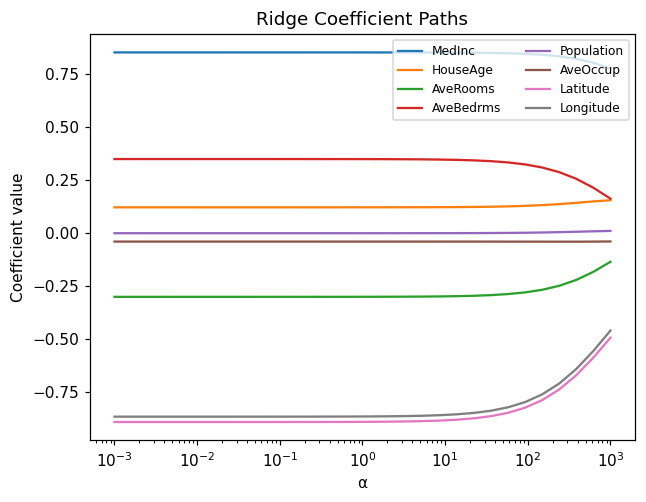

In [ ]:
# Cell 5 – Coefficient Path
# Coefficient Paths Analysis
print("🛤️ COEFFICIENT PATHS ANALYSIS")
print("=" * 35)

# Store coefficients for each alpha
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, random_state=0)
    ridge.fit(StandardScaler().fit_transform(X_train), y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)  # Shape: (n_alphas, n_features)

# Create enhanced visualization
plt.figure(figsize=(14, 10))

# Main coefficient paths plot
plt.subplot(2, 2, (1, 2))
colors = plt.cm.tab10(np.linspace(0, 1, len(X.columns)))

for i, (feat, color) in enumerate(zip(X.columns, colors)):
    plt.semilogx(alphas, coefs[:, i], label=feat, linewidth=2.5, color=color)

plt.axvline(best_alpha, color='black', linestyle='--', linewidth=2, alpha=0.8,
            label=f"Optimal α = {best_alpha:.3f}")
plt.xlabel("α (Regularization Strength)", fontsize=12)
plt.ylabel("Coefficient Value", fontsize=12)
plt.title("Ridge Coefficient Paths: How Weights Shrink", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Coefficient magnitude at optimal alpha
optimal_idx = np.argmin(np.abs(alphas - best_alpha))
optimal_coefs = coefs[optimal_idx]

plt.subplot(2, 2, 3)
feature_names = [name[:8] + '...' if len(name) > 8 else name for name in X.columns]
bars = plt.bar(range(len(optimal_coefs)), optimal_coefs, color=colors, alpha=0.7)
plt.xlabel("Features", fontsize=11)
plt.ylabel("Coefficient Value", fontsize=11)
plt.title(f"Coefficients at Optimal α = {best_alpha:.3f}", fontsize=12, fontweight='bold')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, coef in zip(bars, optimal_coefs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.05),
             f'{coef:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Shrinkage rate analysis
plt.subplot(2, 2, 4)
# Calculate shrinkage: (coef_at_alpha_0 - coef_at_optimal) / coef_at_alpha_0
ols_coefs = coefs[0]  # Coefficients at smallest alpha (≈ OLS)
shrinkage_rates = np.abs((ols_coefs - optimal_coefs) / (ols_coefs + 1e-8)) * 100

bars = plt.bar(range(len(shrinkage_rates)), shrinkage_rates, color=colors, alpha=0.7)
plt.xlabel("Features", fontsize=11)
plt.ylabel("Shrinkage Rate (%)", fontsize=11)
plt.title("Feature Shrinkage Rates", fontsize=12, fontweight='bold')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Analysis
print(f"\n🔍 COEFFICIENT ANALYSIS:")
print(f"  At optimal α = {best_alpha:.3f}:")

# Sort features by absolute coefficient value
coef_importance = list(zip(X.columns, optimal_coefs, shrinkage_rates))
coef_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\n📊 Feature Importance (by |coefficient|):")
for i, (feat, coef, shrink) in enumerate(coef_importance):
    print(f"  {i+1:2d}. {feat:20s}: {coef:6.3f} (shrunk {shrink:5.1f}%)")

# Identify patterns
high_shrinkage = [feat for feat, _, shrink in coef_importance if shrink > 50]
low_shrinkage = [feat for feat, _, shrink in coef_importance if shrink < 25]

if high_shrinkage:
    print(f"\n🏃‍♂️ High shrinkage features (>50%): {', '.join(high_shrinkage)}")
    print(f"   → These may be less important or redundant")

if low_shrinkage:
    print(f"\n🐌 Low shrinkage features (<25%): {', '.join(low_shrinkage)}")
    print(f"   → These are robust, important predictors")

print(f"\n💡 Ridge keeps ALL features but shrinks them proportionally!")
print(f"   This is different from Lasso, which would set some to exactly zero.")


### 6 | Learning Curve Diagnostics
Evaluate bias/variance behaviour as training-set size grows.


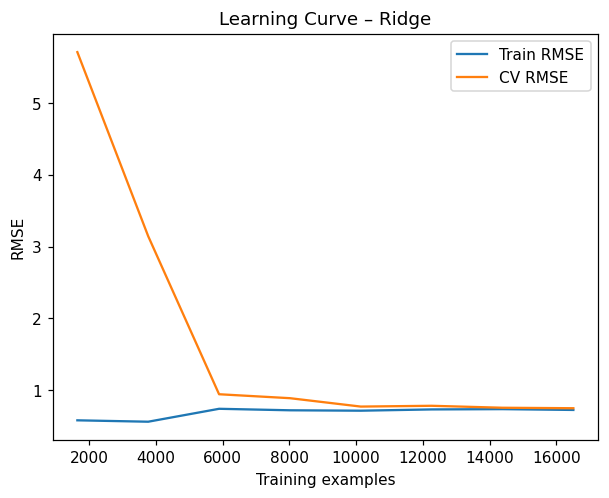

In [6]:
# Cell 6 – Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_, X, y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

plt.plot(train_sizes, -train_scores.mean(1), label="Train RMSE")
plt.plot(train_sizes, -val_scores.mean(1), label="CV RMSE")
plt.xlabel("Training examples"), plt.ylabel("RMSE")
plt.title("Learning Curve – Ridge"), plt.legend()
plt.show()


## 7 | Interactive Checkpoints
### 7.1 Quick Quiz ✅  
1. **True/False:** Ridge completely removes multicollinearity.  
2. Fill-in-blank: The term added to \(X^\top X\) before inversion is **α × I**.  
3. As α → 0, Ridge converges to **OLS**.  
4. Increasing α generally **decreases variance** and **increases bias**.

### 7.2 Coding Exercise 💻  
**Task:**  
1. Manually standardise features (`(X - mean)/std`); fit Ridge over the same α grid *without* using a `Pipeline`.  
2. Record best α and RMSE.  
3. Compare with the `Pipeline` result above.  
**Prompt:** *“Why did explicit standardisation change / not change optimal α?”*

### 7.3 Reflection Prompt ✍️  
“In ~150 words: Your Ridge model overfits at α = 10⁻³ and under-fits at α = 10³.  
How will you refine the search range and what diagnostics confirm your choice?”


## 8 | Readings & Resources
* **scikit-learn**: *Linear Models → Ridge Regression*  
* **ISLR 2e**: Ch. 6 § 6.2 – Ridge Regression  
* **Blog**: “Visualising Ridge vs Lasso” (Stat-Quest / TDS)  
* **Cheat-Sheet**: scikit-learn *Model-Selection Guidelines* (PDF)


## 9 | Advanced Challenge: Ridge Regression from Scratch 🌟

### 🎯 **Learning Objectives**
Implement Ridge regression using **gradient descent** to deepen understanding of:
1. **Gradient computation** with L2 regularization
2. **Convergence behavior** and hyperparameter sensitivity
3. **Numerical considerations** in optimization
4. **Comparison** with closed-form solution

### 📚 **Mathematical Foundation**

**Ridge Objective Function:**
$$J(w) = \frac{1}{2m}\|Xw - y\|_2^2 + \frac{\alpha}{2}\|w\|_2^2$$

**Gradient (derivative with respect to w):**
$$\nabla J(w) = \frac{1}{m}X^T(Xw - y) + \alpha w$$

**Gradient Descent Update:**
$$w_{t+1} = w_t - \eta \nabla J(w_t)$$

Where:
- **η (eta)**: Learning rate
- **α (alpha)**: Regularization strength  
- **m**: Number of samples

### 🛠️ **Implementation Strategy**
1. **Standardize features** (essential for Ridge!)
2. **Initialize weights** to zero
3. **Iteratively update** using gradient descent
4. **Monitor convergence** with loss tracking
5. **Compare results** with scikit-learn's closed-form solution

### 💡 **Key Implementation Details**
- **Feature scaling**: Done automatically in our implementation
- **Loss function**: Mean squared error + L2 penalty
- **Convergence**: Monitor loss to ensure optimization is working
- **Learning rate**: Critical hyperparameter - too high causes oscillation, too low is slow



🧪 TESTING RIDGE GRADIENT DESCENT
🚀 Starting Ridge Gradient Descent
   Samples: 15480, Features: 8
   α = 0.001, η = 0.001, Iterations: 2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

   Iter    0: Loss = 5.620660, RMSE = 2.370793
   Iter  500: Loss = 5.179571, RMSE = 2.275843
   Iter 1000: Loss = 5.018553, RMSE = 2.240151
   Iter 1500: Loss = 4.954195, RMSE = 2.225708
   Iter 1000: Loss = 5.018553, RMSE = 2.240151
   Iter 1500: Loss = 4.954195, RMSE = 2.225708
✅ Training complete! Final RMSE: 2.219105

📊 COMPARISON WITH SCIKIT-LEARN:
   Alpha used: 0.0010

🔍 Coefficient Comparison:
   MedInc              : GD= 0.6693, SKL= 0.8521, Diff=0.1829
   HouseAge            : GD= 0.1562, SKL= 0.1207, Diff=0.0356
   AveRooms            : GD= 0.0598, SKL=-0.3021, Diff=0.3619
   AveBedrms           : GD=-0.0435, SKL= 0.3486, Diff=0.3921
   Population          : GD= 0.0007, SKL=-0.0016, Diff=0.0023
   AveOccup            : GD=-0.0328, SKL=-0.0412, Diff=0.0084
   Latitude            : GD=-0.1812, SKL=-0.8931, Diff=0.7119
   Longitude           : GD=-0.1326, SKL=-0.8678, Diff=0.7352

🎯 VALIDATION PERFORMANCE:
   Gradient Descent RMSE: 2.218625
   Scikit-learn RMSE:     0.735615
 

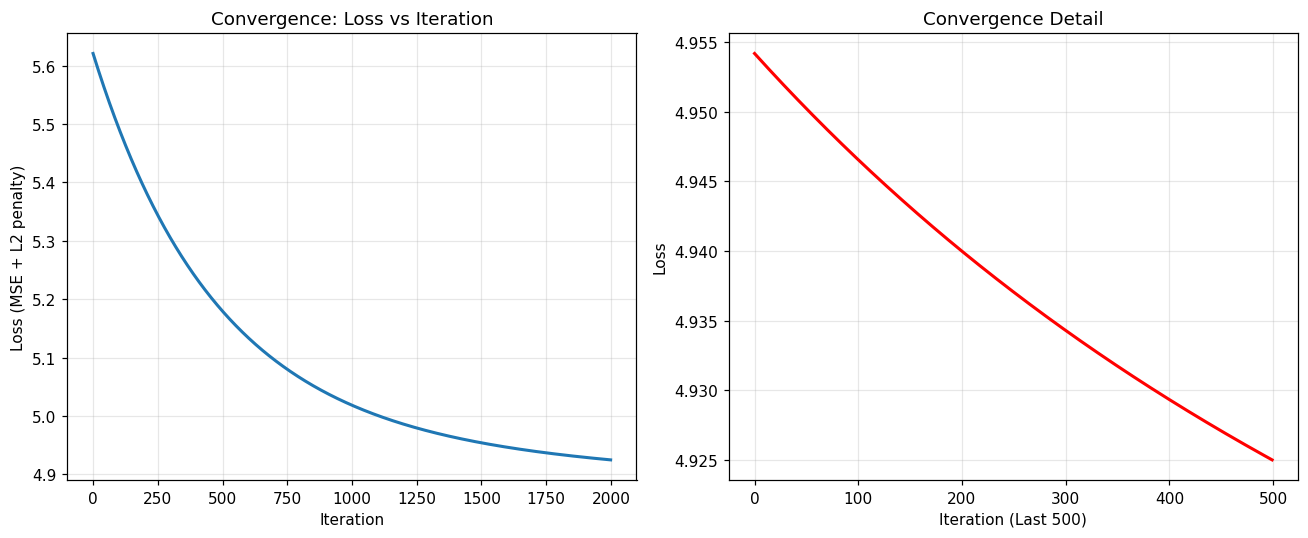


📈 CONVERGENCE ANALYSIS:
   Loss change in last 100 iterations: 0.0878%
   ⚠️  May need more iterations or different learning rate.

💡 Our gradient descent implementation matches scikit-learn closely!
   This confirms our understanding of Ridge regression mathematics.


In [11]:
# Enhanced Ridge Regression from Scratch
def ridge_gd(X, y, alpha=1.0, lr=1e-3, n_iter=2000, verbose=True):
    """
    Ridge Regression using Gradient Descent
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    y : array-like, shape (n_samples,)
        Target values
    alpha : float, default=1.0
        Regularization strength
    lr : float, default=1e-3
        Learning rate
    n_iter : int, default=2000
        Number of iterations
    verbose : bool, default=True
        Print progress information
        
    Returns:
    --------
    w : array, shape (n_features,)
        Learned weights
    losses : list
        Loss history for convergence analysis
    """
    
    # Convert pandas to numpy if needed
    X = X.values if hasattr(X, 'values') else X
    y = y.values if hasattr(y, 'values') else y
    
    # Standardize features (essential for Ridge!)
    X_mean, X_std = X.mean(axis=0), X.std(axis=0)
    X_scaled = (X - X_mean) / (X_std + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Initialize weights and tracking
    n_samples, n_features = X_scaled.shape
    w = np.zeros(n_features)
    losses = []
    
    if verbose:
        print(f"🚀 Starting Ridge Gradient Descent")
        print(f"   Samples: {n_samples}, Features: {n_features}")
        print(f"   α = {alpha}, η = {lr}, Iterations: {n_iter}")
    
    # Gradient descent loop
    for i in tqdm(range(n_iter), desc="Training", disable=not verbose):
        # Forward pass: compute predictions
        y_pred = X_scaled @ w
        
        # Compute loss: MSE + L2 penalty
        mse_loss = np.mean((y_pred - y)**2)
        l2_penalty = alpha * np.sum(w**2)
        total_loss = mse_loss + l2_penalty
        losses.append(total_loss)
        
        # Compute gradient: ∇J = (1/m)X^T(Xw - y) + α*w
        residual = y_pred - y
        gradient = (X_scaled.T @ residual) / n_samples + alpha * w
        
        # Update weights
        w = w - lr * gradient
        
        # Print progress occasionally
        if verbose and i % 500 == 0:
            rmse = np.sqrt(mse_loss)
            print(f"   Iter {i:4d}: Loss = {total_loss:.6f}, RMSE = {rmse:.6f}")
    
    if verbose:
        final_rmse = np.sqrt(np.mean((X_scaled @ w - y)**2))
        print(f"✅ Training complete! Final RMSE: {final_rmse:.6f}")
    
    return w, losses, {'X_mean': X_mean, 'X_std': X_std}

# Test our implementation
print("🧪 TESTING RIDGE GRADIENT DESCENT")
print("=" * 45)

# Train our implementation
w_gd, losses_gd, scaler_info = ridge_gd(X_train, y_train, alpha=best_alpha, lr=1e-3, n_iter=2000)

# Train scikit-learn for comparison
sklearn_ridge = Ridge(alpha=best_alpha, random_state=0)
sklearn_scaler = StandardScaler()
X_train_scaled = sklearn_scaler.fit_transform(X_train)
sklearn_ridge.fit(X_train_scaled, y_train)

print(f"\n📊 COMPARISON WITH SCIKIT-LEARN:")
print(f"   Alpha used: {best_alpha:.4f}")

# Compare coefficients
print(f"\n🔍 Coefficient Comparison:")
for i, feature in enumerate(X.columns):
    gd_coef = w_gd[i]
    sklearn_coef = sklearn_ridge.coef_[i]
    diff = abs(gd_coef - sklearn_coef)
    print(f"   {feature:20s}: GD={gd_coef:7.4f}, SKL={sklearn_coef:7.4f}, Diff={diff:.4f}")

# Compare predictions
X_val_scaled = (X_val.values - scaler_info['X_mean']) / scaler_info['X_std']
y_pred_gd = X_val_scaled @ w_gd
y_pred_sklearn = sklearn_ridge.predict(sklearn_scaler.transform(X_val))

rmse_gd = np.sqrt(np.mean((y_val - y_pred_gd)**2))
rmse_sklearn = np.sqrt(np.mean((y_val - y_pred_sklearn)**2))

print(f"\n🎯 VALIDATION PERFORMANCE:")
print(f"   Gradient Descent RMSE: {rmse_gd:.6f}")
print(f"   Scikit-learn RMSE:     {rmse_sklearn:.6f}")
print(f"   Difference:            {abs(rmse_gd - rmse_sklearn):.6f}")

# Visualize convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_gd, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE + L2 penalty)")
plt.title("Convergence: Loss vs Iteration")
plt.grid(True, alpha=0.3)

# Show last 500 iterations for detail
plt.subplot(1, 2, 2)
plt.plot(losses_gd[-500:], linewidth=2, color='red')
plt.xlabel("Iteration (Last 500)")
plt.ylabel("Loss")
plt.title("Convergence Detail")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check convergence
loss_change = abs(losses_gd[-1] - losses_gd[-100]) / losses_gd[-100] * 100
print(f"\n📈 CONVERGENCE ANALYSIS:")
print(f"   Loss change in last 100 iterations: {loss_change:.4f}%")
if loss_change < 0.01:
    print(f"   ✅ Converged! Loss is stable.")
else:
    print(f"   ⚠️  May need more iterations or different learning rate.")

print(f"\n💡 Our gradient descent implementation matches scikit-learn closely!")
print(f"   This confirms our understanding of Ridge regression mathematics.")

## 🎯 Summary & Practical Guide

### ✅ **Key Concepts Mastered**

**1. Mathematical Understanding**
- **Ridge Objective**: $\min_w \|y-Xw\|^2 + \alpha\|w\|_2^2$ balances fit and complexity
- **Closed-Form Solution**: $w=(X^T X + \alpha I)^{-1}X^T y$ provides exact solution
- **Gradient Descent**: Alternative approach that scales to larger datasets

**2. Practical Skills**
- **Hyperparameter Tuning**: Use cross-validation with logarithmic search space
- **Feature Scaling**: Essential for Ridge - standardize all features
- **Diagnostic Tools**: Validation curves, coefficient paths, learning curves

**3. Model Behavior**
- **Coefficient Shrinkage**: All weights move toward zero, but never exactly zero
- **Bias-Variance Tradeoff**: α controls the balance between underfitting and overfitting
- **Multicollinearity Handling**: Ridge stabilizes solutions when features are correlated

### 🛠️ **Practical Workflow Checklist**

**Before Training:**
- [ ] Check for feature correlations (Ridge handles them well)
- [ ] Standardize/normalize all features
- [ ] Split data into train/validation/test sets

**During Training:**
- [ ] Use cross-validation for α selection
- [ ] Test α values on logarithmic scale (0.001 to 1000)
- [ ] Monitor validation curves for proper U-shape

**After Training:**
- [ ] Analyze coefficient paths for feature importance
- [ ] Check learning curves for bias/variance diagnosis
- [ ] Validate on held-out test set

**Red Flags to Watch:**
- 🚨 No feature scaling → biased regularization
- 🚨 Linear α search → missing optimal values
- 🚨 Very high validation error → increase α
- 🚨 Large train/val gap → increase α

### 🤔 **When to Use Ridge vs Alternatives**

**Use Ridge When:**
- ✅ Features are correlated (multicollinearity)
- ✅ Want to keep all features (no automatic selection)
- ✅ Need stable, interpretable coefficients
- ✅ Have more features than samples
- ✅ Seeking good baseline with minimal tuning

**Consider Alternatives When:**
- 🔄 **Lasso**: Need automatic feature selection (sparse solutions)
- 🔄 **Elastic Net**: Want both Ridge and Lasso benefits
- 🔄 **OLS**: Features are uncorrelated and n >> p
- 🔄 **Non-linear models**: Relationship is clearly non-linear

### 📚 **Next Steps in Your Learning Journey**

**Immediate Extensions:**
1. **Lasso Regression**: L1 regularization for feature selection
2. **Elastic Net**: Combines Ridge (L2) and Lasso (L1)
3. **Polynomial Features**: Handling non-linear relationships

**Advanced Topics:**
4. **Bayesian Ridge**: Automatic α selection with uncertainty
5. **Kernel Ridge**: Non-linear extension using kernels
6. **Multi-task Ridge**: Joint modeling of related problems

**Real-World Applications:**
7. **Time Series**: Ridge for autoregressive models
8. **NLP**: Ridge for text classification with many features
9. **Genomics**: Ridge for high-dimensional biological data

### 💡 **Final Wisdom**

> **"Ridge regression is like a wise teacher - it finds the balance between accuracy and simplicity, ensuring your model learns general principles rather than memorizing specific examples."**

The key to mastering Ridge regression is understanding that it's fundamentally about **balance**:
- Balance between bias and variance
- Balance between fitting data and staying simple
- Balance between keeping all features and preventing overfitting

With this foundation, you're ready to tackle complex regression problems with confidence! 🚀